## Group Assignment

#### Import the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
from scipy.optimize import minimize
import pandas_datareader.data as web
import matplotlib.pyplot as plt

#### All questions in Parts I and II apply to a random sample of 15 stocks that your group will be assigned by running the following code.

#### Random Sample Selection 

In [4]:
np.random.seed (2051 + 11)
ticker_list = ['AAPL', 'AXP', 'BA', 'C','CAT', 'CSCO', 'CVX', 'DIS', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO',
            'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WMT', 'XOM']

stock_list = np.random.choice(ticker_list,15,replace=False)
print(f'These are the fifteen stocks assigned to you: {" ".join(stock_list)}')

These are the fifteen stocks assigned to you: V JNJ CAT CSCO CVX C NKE TRV MCD INTC DIS IBM PFE GS MRK


### PART I

#### 1. Find the optimal portfolio over the period January 2015 - December 2019, using the fifteen stocks assigned to your group. Assume there are no short-selling constraints.

In [5]:
start=dt.datetime(2015,1,1)
end=dt.datetime(2019,12,31)
df=yf.download(list(stock_list),start-pd.offsets.BDay(1),end+pd.offsets.BDay(1))['Adj Close'].pct_change().dropna()
df.head()

[*********************100%***********************]  15 of 15 completed


,C,CAT,CSCO,CVX,DIS,GS,IBM,INTC,JNJ,MCD,MRK,NKE,PFE,TRV,V
Date,,,,,,,,,,,,,,,
2015-01-02,0.002772,0.003824,-0.000724,0.003565,-0.004672,0.002992,0.010097,0.001929,-0.000478,-0.004696,0.007043,-0.011648,0.005779,-0.003873,0.010755
2015-01-05,-0.031515,-0.052786,-0.019921,-0.039971,-0.014613,-0.031223,-0.015735,-0.011276,-0.006984,-0.011044,0.014863,-0.016100,-0.005426,-0.012045,-0.022074
2015-01-06,-0.035205,-0.006435,-0.000369,-0.000463,-0.005304,-0.020229,-0.021566,-0.018637,-0.004914,0.001843,0.039283,-0.005882,0.008344,-0.008928,-0.006444
2015-01-07,0.009270,0.015496,0.009242,-0.000833,0.010229,0.014903,-0.006535,0.020975,0.022076,0.017424,0.021386,0.020656,0.013686,0.017048,0.013398
2015-01-08,0.015048,0.010250,0.007692,0.022883,0.010342,0.015966,0.021735,0.018601,0.007863,0.003723,0.020127,0.023084,0.020408,0.020762,0.013412


In [6]:
df = df.resample(rule = 'M').apply(lambda x: x.add(1).prod().sub(1))
df.tail()

,C,CAT,CSCO,CVX,DIS,GS,IBM,INTC,JNJ,MCD,MRK,NKE,PFE,TRV,V
Date,,,,,,,,,,,,,,,
2019-08-31,-0.088902,-0.096225,-0.155054,-0.033952,-0.040207,-0.067870,-0.074967,-0.055784,-0.006897,0.039875,0.041933,-0.015247,-0.076144,0.002319,0.017309
2019-09-30,0.073504,0.061428,0.055544,0.007475,-0.050561,0.016282,0.072972,0.086901,0.007946,-0.014956,-0.020014,0.111479,0.010689,0.017229,-0.048723
2019-10-31,0.040243,0.099542,-0.031171,-0.020742,-0.003069,0.029677,-0.080388,0.097031,0.020560,-0.083880,0.029461,-0.046529,0.067910,-0.118569,0.039823
2019-11-30,0.052838,0.050290,-0.046306,0.018462,0.166718,0.043200,0.017259,0.032540,0.048490,-0.004950,0.006000,0.046722,0.013612,0.043186,0.033317
2019-12-31,0.063498,0.020383,0.058486,0.028857,-0.040134,0.038762,-0.003050,0.031008,0.060950,0.016094,0.050397,0.083645,0.017134,0.007771,0.018373


In [7]:
rf = web.DataReader('F-F_Research_Data_Factors','famafrench', start, end)[0][['RF']].div(100)

rf.index = rf.index.to_timestamp(how='end').normalize()

rf.tail()

,RF
Date,
2019-08-31,0.0016
2019-09-30,0.0018
2019-10-31,0.0016
2019-11-30,0.0012
2019-12-31,0.0014


In [8]:
df = df[df.index<=rf.index[-1]]

In [9]:
# Define the portfolio returns function
def port_ret(weights):
    port_ret = np.dot(df*12,weights).mean()
    return port_ret

# Define the portfolio standard deviation function
def port_std(weights):
    port_std = np.sqrt(np.dot(weights, np.dot(df.cov()*12, weights)))
    return port_std

# Define the excess portfolio returns function
def ex_port_ret(weights):
    ex_port_ret = (np.dot(df,weights) - rf['RF']).mean()*12
    return ex_port_ret

# Define the excess portfolio standard deviation function
def ex_port_std(weights):
    ex_port_std = (np.dot(df,weights) - rf['RF']).std()*np.sqrt(12)
    return ex_port_std

# Define the negative Sharpe Ratio function that we will minimize
def neg_SR(weights):
    SR = ex_port_ret(weights) / ex_port_std(weights)
    return (-1)*SR

In [10]:
# setting up constraints
constraints = ({'type':'eq','fun': lambda weights: np.sum(weights) - 1})

# equally weighted first guess
init_guess = np.full(len(df.columns), 1/len(df.columns))

In [11]:
# creating the optimal portfolio
optimal_port = minimize(neg_SR,init_guess,constraints=constraints)
optimal_port

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -2.0213684469216635
       x: [-1.205e-01  1.228e-01 ... -3.061e-01  4.201e-01]
     nit: 14
     jac: [-7.703e-02 -7.684e-02 ... -7.632e-02 -7.712e-02]
    nfev: 233
    njev: 14

#### 2. What are the weights of the stocks in the optimal portfolio?

In [13]:
# weights of portfolio
for tic in stock_list:
    print(tic + "  "+ str(round(optimal_port.x[list(stock_list).index(tic)],4)))

V  -0.1205
JNJ  0.1228
CAT  -0.0277
CSCO  -0.2561
CVX  -0.0294
C  0.1097
NKE  -0.106
TRV  0.1266
MCD  -0.0792
INTC  0.6043
DIS  0.1724
IBM  0.3012
PFE  0.068
GS  -0.3061
MRK  0.4201


#### 3. What was the annualized average monthly return for the optimal portfolio?

In [14]:
# portfolio return
port_ret(optimal_port.x)

0.26289008712391326

#### 4. What was the annualized monthly standard deviation for the optimal portfolio?

In [15]:
# std of portfolio
port_std(optimal_port.x)

0.12531897047134832

#### 5. What was the Sharpe Ratio of the optimal portfolio?

In [16]:
# sharpe ratio
-optimal_port.fun

2.0213684469216635

### PART II

#### 1. Create a DataFrame named optimal_weights to store the weights from a portfolio optimization performed on a rolling basis. Specifically, the optimization should use a 60 month rolling window, and be performed every month. The first 60 months correspond to the sample period for data_initial (01/2015 - 12/2019) created in question 3. Hence, the first observation in the optimal_weights DataFrame should be the weights you listed above in Part I. The next 60 month period should be 02/2015 - 01/2020, followed by 03/2015 - 02/2020, and so on. The last 60 month period should be 03/2018 - 02/2023. Again, assume there are no short-selling constraints.

In [17]:
# getting risk free rates
start = dt.datetime(2015,1,1)
end = dt.datetime(2023,3,31)
rf = web.DataReader('F-F_Research_Data_Factors','famafrench', start, end)[0][['RF']].div(100)
rf.index = rf.index.to_timestamp(how='end').normalize()
rf.tail()

,RF
Date,
2022-10-31,0.0023
2022-11-30,0.0029
2022-12-31,0.0033
2023-01-31,0.0035
2023-02-28,0.0034


In [53]:
# getting the stock returns
df1 = yf.download(list(stock_list),start-pd.offsets.BDay(1),end+pd.offsets.BDay(1))['Adj Close']
df = df1.pct_change().dropna()
df = df.resample(rule = 'M').apply(lambda x: x.add(1).prod().sub(1))
df = df[df.index<=rf.index[-1]]
df

# monthly $1 values
investments = pd.DataFrame()
for column in df1:
    investments[column] = df1[column]/df1[column].iloc[0]
investments = investments.resample('M').last()

[*********************100%***********************]  15 of 15 completed


,C,CAT,CSCO,CVX,DIS,GS,IBM,INTC,JNJ,MCD,MRK,NKE,PFE,TRV,V
Date,,,,,,,,,,,,,,,
2015-01-31,-0.132139,-0.119133,-0.045602,-0.086022,-0.034293,-0.110510,-0.044440,-0.089556,-0.042364,-0.013447,0.061455,-0.040562,0.003210,-0.028626,-0.027803
2015-02-28,0.116506,0.036638,0.119075,0.050698,0.144239,0.104262,0.063701,0.013574,0.030833,0.079180,-0.028865,0.055845,0.107928,0.044933,0.066271
2015-03-31,-0.017169,-0.034620,-0.059956,-0.015935,0.007782,-0.009589,-0.008892,-0.059549,-0.018633,-0.014762,-0.010162,0.033052,0.013695,0.011593,-0.035642
2015-04-30,0.034938,0.094590,0.047221,0.057916,0.036514,0.044954,0.067227,0.040934,-0.013916,-0.009134,0.036186,-0.014851,-0.024720,-0.064922,0.009785
2015-05-31,0.015215,-0.017956,0.016649,-0.063332,0.015177,0.053014,-0.002079,0.066334,0.016837,0.002213,0.022330,0.031440,0.032642,0.000099,0.041638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-31,0.100552,0.328062,0.146300,0.259135,0.129439,0.175601,0.163959,0.103221,0.064949,0.181676,0.175104,0.115014,0.063757,0.204047,0.166113
2022-11-30,0.067820,0.092165,0.094431,0.021161,-0.081378,0.128218,0.089560,0.071971,0.029769,0.006112,0.088142,0.183535,0.086137,0.029004,0.049841
2022-12-31,-0.065689,0.013324,-0.041834,-0.020839,-0.112292,-0.110760,-0.053794,-0.121051,-0.007584,-0.033946,0.014213,0.070008,0.022142,-0.007313,-0.042581


In [26]:
# portfolio optimization on a 60 month rolling basis

optimal_weights = pd.DataFrame()

for i in range(0, len(df.index)-60+1):
    
    # Define the negative Sharpe Ratio function that we will minimize
    def neg_SR(weights):
        # excess return
        r = (np.dot(df.iloc[i:i+60],weights) - rf.iloc[i:i+60]['RF']).mean()*12
        # excess SD
        s = (np.dot(df.iloc[i:i+60],weights) - rf.iloc[i:i+60]['RF']).std()*np.sqrt(12)
        return (-1) * (r/s)

    # By convention of minimize function it should be a function that returns zero for conditions
    constraints = ({'type':'eq','fun': lambda weights: np.sum(weights) - 1})

    # Initial Guess (equally weighted)
    init_guess = np.full(len(df.columns),1/len(df.columns))
    
    optimal_port = minimize(neg_SR, init_guess, constraints=constraints)
    
    optimal_weights = pd.concat([optimal_weights,
                                pd.DataFrame(optimal_port.x.reshape(1,len(stock_list)).round(4),
                                             columns=[stock_list],
                                             index=[df.iloc[i:i+60].index[-1]])],
                                axis=0)

In [112]:
optimal_weights.tail()

,V,JNJ,CAT,CSCO,CVX,C,NKE,TRV,MCD,INTC,DIS,IBM,PFE,GS,MRK
2022-10-31,-0.9402,0.2750,0.2145,0.3473,-0.5433,0.9493,-0.3793,-0.7729,0.0156,0.1283,0.2858,0.1731,0.1675,0.2013,0.8779
2022-11-30,-0.9395,0.2749,0.1375,0.3106,-0.6282,1.0477,-0.3619,-0.7359,-0.0026,0.0591,0.3471,0.1459,0.1885,0.2160,0.9408
2022-12-31,-0.8701,0.2103,0.1085,0.3244,-0.7269,0.9525,-0.4094,-0.8050,0.1122,0.0213,0.2772,0.2700,0.2105,0.3245,0.9999
2023-01-31,-0.7856,0.3705,0.1212,0.1991,-0.5322,0.9208,-0.5610,-0.8488,-0.2097,0.2531,0.4200,0.2480,0.1419,0.1149,1.1478
2023-02-28,-0.6870,0.3825,-0.0005,0.2298,-0.4503,0.8285,-0.4325,-0.9087,-0.1733,0.4979,0.5466,0.2367,0.0186,0.0610,0.8505


#### 2. Create a new DataFrame named port_returns to store the monthly returns over the sample period 01/2020 - 02/2023 for the following portfolios:
 1) A monthly rebalanced portfolio using the rolling optimal weights. Specifically, the portfolio return for 01/2020 should be based on the weights as of 12/2019 (the same values detailed in Part I and in the first row in the optimal_weights DataFrame), the portfolio return for 02/2020 should be based on the weights as of 01/2020 and so on. Label the portfolio (MRoll_Reb_OP, an acronym for Monthly Rolling Rebalanced Optimal Portfolio). 
 2) A monthly rebalanced portfolio using the optimal weights as of 12/2019. Label the portfolio (M_Reb_OP, an acronym for Monthly Rebalancing Optimal Portfolio).
 3) A monthly rebalanced equally-weighted portfolio. Label the portfolio (M_Reb_EW, an acronym for Monthly Rebalancing Equally-Weighted Portfolio).
 4) A buy and hold portfolio, initially allocated according to the optimal weights as of 12/2019. Label the portfolio (BH_OP, an acronym for Buy and Hold Optimal Portfolio).
 5) A buy and hold portfolio, initially allocated equally across stocks. Label the portfolio (BH_EW, an acronym for Buy and Hold Equally-Weighted Portfolio).

In [129]:
port_returns = pd.DataFrame()
eq_weights = [1/len(stock_list)]*len(stock_list)

#1
for i in range(0,len(optimal_weights)-1):
    port_returns = pd.concat([port_returns,
                              pd.DataFrame({'MRoll_Reb_OP':np.dot(optimal_weights.iloc[i],df.iloc[i+60])},
                                           index = [df.index[i+60]])],
                                           axis=0)
    
#2-5
port_returns['M_Reb_OP'] = np.dot(df.iloc[60:], optimal_weights.iloc[0])
port_returns['M_Reb_EW'] = np.dot(df.iloc[60:], eq_weights)
t1 = np.dot(investments.iloc[60:-1], optimal_weights.iloc[0])
t2 = np.dot(investments.iloc[60:-1], eq_weights)
port_returns['BH_OP'] = pd.DataFrame(t1).pct_change().dropna()[0].values.tolist()
port_returns['BH_EW'] = pd.DataFrame(t2).pct_change().dropna()[0].values.tolist()

port_returns

,MRoll_Reb_OP,M_Reb_OP,M_Reb_EW,BH_OP,BH_EW
2020-01-31,0.087077,0.087077,-0.013858,0.062829,-0.010081
2020-02-29,-0.074547,-0.073466,-0.106120,-0.080436,-0.103570
2020-03-31,-0.019374,-0.023884,-0.117325,-0.079124,-0.108324
2020-04-30,-0.009042,0.071595,0.115722,0.095093,0.106652
2020-05-31,0.100065,0.075926,0.046722,0.062537,0.051604
2020-06-30,-0.022821,-0.040443,-0.016224,-0.021460,-0.019059
2020-07-31,-0.020522,0.034641,0.011435,0.015191,0.007654
2020-08-31,0.170738,0.171205,0.050088,0.132267,0.057988
2020-09-30,0.114181,0.111449,-0.029253,0.040490,-0.017420
2020-10-31,-0.078313,-0.110598,-0.043091,-0.070928,-0.047193


#### 3. Create a DataFrame port_stats (with a 3x5 shape) to store the annualized average monthly return, the annualized monthly standard deviation and the Sharpe ratio for all 5 portfolios.

In [156]:
# excess port_ret
ex_pr = pd.DataFrame()
for c in port_returns.columns:
    ex_pr[c] = port_returns[c] - rf[60:].RF

lst = [port_returns.mean()*12, 
       port_returns.std()*np.sqrt(12), 
       (ex_pr.mean()*12)/(ex_pr.std()*np.sqrt(12))]

port_stats = pd.DataFrame(lst, index=['Annualized Average Monthly Return',
                         'Annualized Monthly Standard Deviation', 
                         'Sharpe Ratio'])

port_stats

,MRoll_Reb_OP,M_Reb_OP,M_Reb_EW,BH_OP,BH_EW
Annualized Average Monthly Return,0.177738,0.101208,0.089667,0.108482,0.079957
Annualized Monthly Standard Deviation,0.352188,0.268049,0.218372,0.227779,0.212967
Sharpe Ratio,0.481903,0.347234,0.372307,0.440281,0.336386


#### 4. Compute the cumulative return series for all portfolios and plot them in the same graph. 

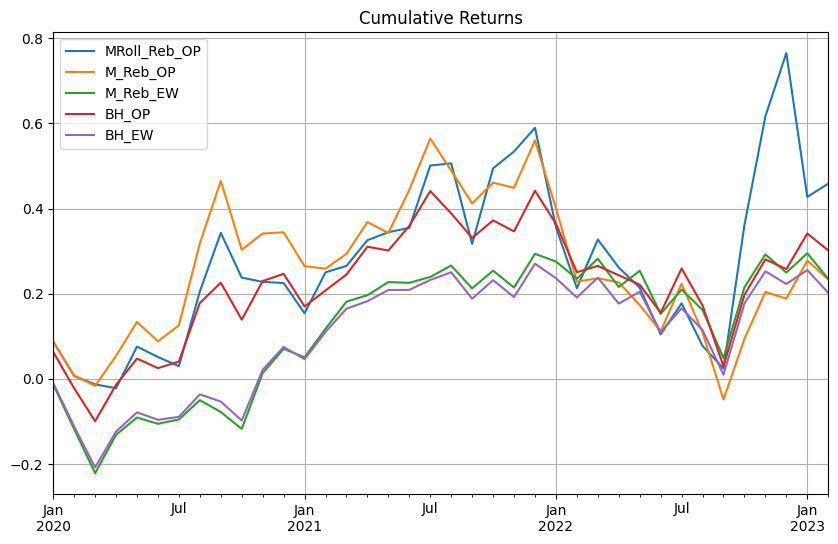

In [168]:
cum_df = pd.DataFrame()
for c in port_returns.columns:
    cum_df[c] = port_returns[c].add(1).cumprod()-1
    
cum_df.plot.line(y = cum_df.columns, 
                     figsize = (10,6), grid = True, title = 'Cumulative Returns');

#### 5. What was the cumulative return for the best performing portfolio? What was the cumulative return for the worst performing portfolio?

In [172]:
cum_ret = cum_df.iloc[-1,:]
print('cumulative return for the best performing portfolio', cum_ret.max())
print('cumulative return for the worst performing portfolio', cum_ret.min())

cumulative return for the best performing portfolio 0.45837263846560417
cumulative return for the worst performing portfolio 0.2018173316561498


### PART III - Examination of the Size Effect

Please download the file "crsp_fall22.csv" located in folder Group_Assignment. The file contains the following columns:
* PERMNO - Permanent number (unique identifer for the stock)
* DATE
* PRC - The closing price
* VOL - Trading volume (in hundreds)
* RET - The simple return
* SHROUT - The number of shares outstanding (in thousands)
* CFACPR - Cumulative factor to adjust the closing price
* CFACSHR - Cumulative factor to adjust shares outstanding

#### 1. Create a DataFrame named fin_data by reading in the columns DATE, PERMNO, RET, PRC and SHROUT from the file 'crsp_fall22.csv'. Set the DATE as the index. In addition, change each index value to the end of the month. For example, change '1926-05-30' to 1926-05-31', or '1987-01-30' to '1987-01-31'. In addition, create a new column (labeled MKTCAP) to store the market capitalization (defined as PRC * SHROUT). Subsequently, permanently remove the PRC and SHROUT columns.

In [109]:
fin_data = pd.read_csv('crsp_fall22.csv', dtype={'PERMNO':np.int64},
                       usecols=['DATE', 'PERMNO', 'RET', 'PRC', 'SHROUT'])

# convert date col and make the end of the month the index
fin_data['DATE'] = pd.to_datetime(fin_data['DATE'], format='%Y-%m-%d')
fin_data.set_index('DATE', inplace=True)
fin_data.index = fin_data.index + pd.offsets.MonthEnd(0)

# create the MKTCAP column
fin_data['MKTCAP'] = fin_data['PRC'] * fin_data['SHROUT']

# drop cols
fin_data.drop(columns=['PRC', 'SHROUT'], inplace=True)

In [110]:
fin_data

,PERMNO,RET,MKTCAP
DATE,,,
1990-01-31,21573,-0.106195,5.499450e+06
1990-01-31,55160,-0.190476,2.067094e+03
1990-01-31,45129,-0.086420,1.892550e+05
1990-01-31,22250,-0.174684,3.117920e+05
1990-01-31,60468,-0.071429,2.227225e+04
...,...,...,...
2022-03-31,16400,-0.070234,2.676084e+05
2022-03-31,16401,0.424749,9.943693e+04
2022-03-31,90664,0.236017,4.965897e+07


#### 2. How many stocks are there in the sample? How many of these stocks are in the sample over the entire sample period?

In [111]:
num_stocks = fin_data['PERMNO'].nunique()
print(f"The number of stocks in the sample is: {num_stocks}")

num_entire_stocks = fin_data.groupby('PERMNO').size().value_counts().loc[fin_data.index.nunique()]
print(f"The number of stocks in the sample over the entire sample period is: {num_entire_stocks}")

The number of stocks in the sample is: 18153
The number of stocks in the sample over the entire sample period is: 697


#### 3. Every June, split the stocks into quintiles (five groups) based on their market capitalization. The header of a DataFrame named size_qt with the resulting split can be found below. 

In [112]:
split_qt = fin_data.copy()
# splitting into quintiles based off market cap

split_qt['MKTCAP_QT'] = split_qt.groupby(pd.Grouper(freq='A-JUN'))['MKTCAP'].apply(lambda x: pd.qcut(x, 5, labels=False) + 1)

size_qt = split_qt.reset_index()[['PERMNO', 'MKTCAP_QT', 'DATE']]

# filter for only june
size_qt = size_qt[size_qt['DATE'].dt.month == 6]
size_qt = size_qt.set_index('DATE').sort_index()

# offsetting to hit july
size_qt.index = size_qt.index + pd.offsets.MonthEnd()

In [113]:
size_qt.sort_index().head()

,PERMNO,MKTCAP_QT
DATE,,
1990-07-31,10294,3
1990-07-31,65496,3
1990-07-31,10905,2
1990-07-31,32037,1
1990-07-31,66288,5


#### 4. Create a new DataFrame named data by using the merge_asof() function to merge the DataFrames fin_data and size_qt. Specifically, merge each stock's June quintile allocation with the stock's monthly returns for the next 12 months starting the following July. Subsequently, set DATE as the index in the DataFrame.

In [114]:
data = pd.merge_asof(fin_data, size_qt, 
                            on='DATE',
                            by='PERMNO', direction='backward')

data.set_index('DATE', inplace=True)

# dropping first 6 months
data.dropna(inplace=True)

#### 5. Create a new DataFrame called quintiles to store the average monthly return for each quintile. The header of the DataFrame can be found below:

In [115]:
# taking the mean and unstacking the quantiles
quintiles = data.groupby(['DATE', 'MKTCAP_QT'])['RET'].mean().unstack()
quintiles.columns = ['Q1_RET', 'Q2_RET', 'Q3_RET', 'Q4_RET', 'Q5_RET']

In [116]:
quintiles.head()

,Q1_RET,Q2_RET,Q3_RET,Q4_RET,Q5_RET
DATE,,,,,
1990-07-31,-0.001239,-0.043007,-0.041412,-0.041637,-0.028809
1990-08-31,-0.087260,-0.111380,-0.133862,-0.134542,-0.111322
1990-09-30,-0.044903,-0.091021,-0.092244,-0.098746,-0.081242
1990-10-31,-0.069386,-0.064657,-0.071607,-0.060954,-0.039792
1990-11-30,-0.011271,0.002051,0.027951,0.069232,0.100039


#### 6. Create a bar plot of the average monthly return for all five market capitalization groups, across the entire sample.

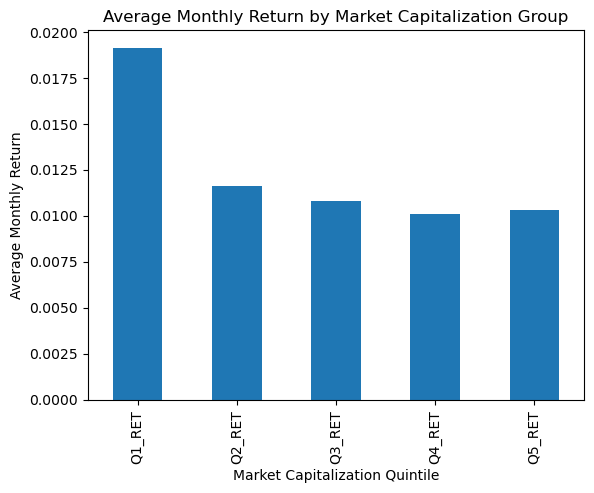

In [117]:
quintiles.mean().plot(kind='bar')

# plotting basics
plt.title('Average Monthly Return by Market Capitalization Group')
plt.xlabel('Market Capitalization Quintile')
plt.ylabel('Average Monthly Return')
plt.show()

#### 7. Create a line plot of the cumulative return series for all five market capitalization groups.

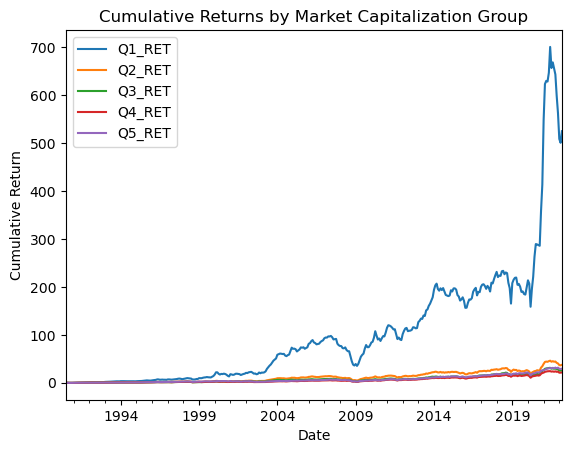

In [118]:
cumulative_returns = (1 + quintiles).cumprod() - 1

# plot cumulative returns
cumulative_returns.plot(kind='line')

plt.title('Cumulative Returns by Market Capitalization Group')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()